<a href="https://colab.research.google.com/github/sjquill/MSc_diss/blob/main/Breast_FPSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

FPSA (Flexible Parametric Survival Analysis)

In [ ]:
!pip install lifelines
!pip install scikit-survival

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.4/409.4 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.9/88.9 kB 5.1 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=3cb06e3dbc699afec824592602077240cc8e439aabb0cfc92450b8afb34e1819
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 9.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd

breast_train_data_imputed1 = pd.read_csv("/content/drive/MyDrive/MSc_summer_project/Clinical_trial_data/Breast/breast_train_data_imputed1.csv")
breast_test_data_imputed1 = pd.read_csv("/content/drive/MyDrive/MSc_summer_project/Clinical_trial_data/Breast/breast_test_data_imputed1.csv")


In [ ]:
train_data = breast_train_data_imputed1.copy()
test_data = breast_test_data_imputed1.copy()

In [ ]:
column_names = [
    'mask_id',
    'disease_free_survival_status',
    'disease_free_survival_months',
    'race_asian',
    'race_black',
    'race_other',
    'Treatment_CA_6',
    'Treatment_T_4',
    'Treatment_T_6',
    'post_menopausal',
    'tumor_side_right',
    'tumor_side_bilateral',
    'receptor_status_er_pos',
    'receptor_status_pgrn_pos',
    'histologic_grade_inter',
    'histologic_grade_high',
    'her2_status_pos',
    'prior_hormonal_therapy_yes',
    'most_extensive_primary_surgery_mast_NOS',
    'tumor_size_2_to_5cm',
    'tumor_size_over_5cm',
    'num_pos_nodes_1',
    'num_pos_nodes_2+',
    'age_over_fifty'
]
# Set the new column names
train_data.columns = column_names
test_data.columns = column_names

In [ ]:
import numpy as np

train_data_y = np.empty(len(train_data), dtype=[('disease_free_survival_status', bool), ('disease_free_survival_months', float)])
train_data_y['disease_free_survival_status'] = train_data['disease_free_survival_status'].astype(bool)
train_data_y['disease_free_survival_months'] = train_data['disease_free_survival_months']

train_data_x = train_data.drop(columns=['mask_id'])

# Repeat for test data.

test_data_y = np.empty(len(test_data), dtype=[('disease_free_survival_status', bool), ('disease_free_survival_months', float)])
test_data_y['disease_free_survival_status'] = test_data['disease_free_survival_status'].astype(bool)
test_data_y['disease_free_survival_months'] = test_data['disease_free_survival_months']

test_data_x = test_data.drop(columns=['mask_id'])


In [ ]:
from lifelines import CoxPHFitter
from sklearn.model_selection import KFold
from lifelines.utils import concordance_index
import numpy as np

cph = CoxPHFitter(
    baseline_estimation_method="spline",
    n_baseline_knots=4
)

In [ ]:
cph.fit(train_data_x, duration_col='disease_free_survival_months',
        event_col='disease_free_survival_status')

<lifelines.CoxPHFitter: fitted with 2500 total observations, 2232 right-censored observations>

In [ ]:
from lifelines.utils import concordance_index

# Calculate the concordance index for the test set
c_index = concordance_index(test_data_x['disease_free_survival_months'], cph.predict_expectation(test_data_x), test_data_x['disease_free_survival_status'])

print("Concordance Index (C-index):", c_index)

/usr/local/lib/python3.10/dist-packages/lifelines/fitters/__init__.py:2496: ApproximationWarning: Approximating the expected value using trapezoid rule.

  warnings.warn("""Approximating the expected value using trapezoid rule.\n""", exceptions.ApproximationWarning)


Concordance Index (C-index): 0.6394543458062336


In [ ]:
from sklearn.model_selection import KFold
import numpy as np
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from scipy.integrate import trapz
import time



def calculate_c_index(model, X):
    predictions = model.predict_expectation(X)
    return concordance_index(X['disease_free_survival_months'], predictions, X['disease_free_survival_status'])

param_grid = {'n_baseline_knots': [2, 4, 6, 8, 10, 12, 14]}
c_index_scores = []
ibs_scores = []
training_times = []
k_fold = KFold(n_splits=5)

for n_knots in param_grid['n_baseline_knots']:
    try:
        print(f"Training model with {n_knots} knots...")
        cph = CoxPHFitter(baseline_estimation_method="spline", n_baseline_knots=n_knots)

        c_index_scores_cv = []
        ibs_scores_cv = []
        for train_index, val_index in k_fold.split(train_data_x):
            train_x, val_x = train_data_x.iloc[train_index], train_data_x.iloc[val_index]

            start_training_time = time.time()
            cph.fit(train_x, duration_col='disease_free_survival_months', event_col='disease_free_survival_status')
            end_training_time = time.time()
            training_times.append(end_training_time - start_training_time)

            c_index = calculate_c_index(cph, val_x)
            c_index_scores_cv.append(c_index)

            times = np.sort(val_x["disease_free_survival_months"].unique())
            survival = cph.predict_survival_function(val_x, times=times)
            brier_scores = []
            for t in times:
                y_true = (val_x["disease_free_survival_months"].values <= t) * val_x["disease_free_survival_status"]
                y_pred = 1 - survival.loc[t].values
                brier_score = np.mean((y_true - y_pred) ** 2)
                brier_scores.append(brier_score)

            ibs = trapz(brier_scores, times) / (times.max() - times.min())
            ibs_scores_cv.append(ibs)

        c_index_scores.append(np.mean(c_index_scores_cv))
        ibs_scores.append(np.mean(ibs_scores_cv))

        print(f"Average C-index score for {n_knots} knots: {np.mean(c_index_scores_cv)}")
        print(f"Average Integrated Brier Score for {n_knots} knots: {np.mean(ibs_scores_cv)}")
        print(f"Training time for {n_knots} knots: {end_training_time - start_training_time}")
    except Exception as e:
        print(f"An error occurred with {n_knots} knots: {e}")

best_n_knots = param_grid['n_baseline_knots'][np.argmax(c_index_scores)]
print("Best number of knots:", best_n_knots)
print("Average Concordance Index (C-index) for the best model on validation:", max(c_index_scores))
print("Average Integrated Brier Score (IBS) for the best model on validation:", ibs_scores[np.argmax(c_index_scores)])
print("Average training time for the best model:", np.mean(training_times))

# Print total training time for all knots
total_training_time = sum(training_times)
print("Total training time for all knots:", total_training_time)



Training model with 2 knots...


/usr/local/lib/python3.10/dist-packages/lifelines/fitters/__init__.py:2496: ApproximationWarning: Approximating the expected value using trapezoid rule.

  warnings.warn("""Approximating the expected value using trapezoid rule.\n""", exceptions.ApproximationWarning)
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/__init__.py:2496: ApproximationWarning: Approximating the expected value using trapezoid rule.

  warnings.warn("""Approximating the expected value using trapezoid rule.\n""", exceptions.ApproximationWarning)
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/__init__.py:2496: ApproximationWarning: Approximating the expected value using trapezoid rule.

  warnings.warn("""Approximating the expected value using trapezoid rule.\n""", exceptions.ApproximationWarning)
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/__init__.py:2496: ApproximationWarning: Approximating the expected value using trapezoid rule.

  warnings.warn("""Approximating the expected

Average C-index score for 2 knots: 0.5905690316831804
Average Integrated Brier Score for 2 knots: 0.06600704545080946
Training time for 2 knots: 3.6946988105773926
Training model with 4 knots...


/usr/local/lib/python3.10/dist-packages/lifelines/fitters/__init__.py:2496: ApproximationWarning: Approximating the expected value using trapezoid rule.

  warnings.warn("""Approximating the expected value using trapezoid rule.\n""", exceptions.ApproximationWarning)
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/__init__.py:2496: ApproximationWarning: Approximating the expected value using trapezoid rule.

  warnings.warn("""Approximating the expected value using trapezoid rule.\n""", exceptions.ApproximationWarning)
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/__init__.py:2496: ApproximationWarning: Approximating the expected value using trapezoid rule.

  warnings.warn("""Approximating the expected value using trapezoid rule.\n""", exceptions.ApproximationWarning)
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/__init__.py:2496: ApproximationWarning: Approximating the expected value using trapezoid rule.

  warnings.warn("""Approximating the expected

Average C-index score for 4 knots: 0.5020258746941867
Average Integrated Brier Score for 4 knots: 0.07711198745358078
Training time for 4 knots: 2.617549180984497
Training model with 6 knots...


/usr/local/lib/python3.10/dist-packages/lifelines/fitters/__init__.py:2496: ApproximationWarning: Approximating the expected value using trapezoid rule.

  warnings.warn("""Approximating the expected value using trapezoid rule.\n""", exceptions.ApproximationWarning)
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/__init__.py:2496: ApproximationWarning: Approximating the expected value using trapezoid rule.

  warnings.warn("""Approximating the expected value using trapezoid rule.\n""", exceptions.ApproximationWarning)
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/__init__.py:2496: ApproximationWarning: Approximating the expected value using trapezoid rule.

  warnings.warn("""Approximating the expected value using trapezoid rule.\n""", exceptions.ApproximationWarning)
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/__init__.py:2496: ApproximationWarning: Approximating the expected value using trapezoid rule.

  warnings.warn("""Approximating the expected

Average C-index score for 6 knots: 0.5798105857239731
Average Integrated Brier Score for 6 knots: 0.06851836064448907
Training time for 6 knots: 3.953112840652466
Training model with 8 knots...


/usr/local/lib/python3.10/dist-packages/lifelines/fitters/__init__.py:2496: ApproximationWarning: Approximating the expected value using trapezoid rule.

  warnings.warn("""Approximating the expected value using trapezoid rule.\n""", exceptions.ApproximationWarning)
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/__init__.py:2496: ApproximationWarning: Approximating the expected value using trapezoid rule.

  warnings.warn("""Approximating the expected value using trapezoid rule.\n""", exceptions.ApproximationWarning)
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/__init__.py:2496: ApproximationWarning: Approximating the expected value using trapezoid rule.

  warnings.warn("""Approximating the expected value using trapezoid rule.\n""", exceptions.ApproximationWarning)
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/__init__.py:2496: ApproximationWarning: Approximating the expected value using trapezoid rule.

  warnings.warn("""Approximating the expected

Average C-index score for 8 knots: 0.5846150086797465
Average Integrated Brier Score for 8 knots: 0.07187541913707718
Training time for 8 knots: 6.344585418701172
Training model with 10 knots...


/usr/local/lib/python3.10/dist-packages/lifelines/fitters/__init__.py:2496: ApproximationWarning: Approximating the expected value using trapezoid rule.

  warnings.warn("""Approximating the expected value using trapezoid rule.\n""", exceptions.ApproximationWarning)
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/__init__.py:2496: ApproximationWarning: Approximating the expected value using trapezoid rule.

  warnings.warn("""Approximating the expected value using trapezoid rule.\n""", exceptions.ApproximationWarning)
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/__init__.py:2086: StatisticalWarning: The diagonal of the variance_matrix_ has negative values. This could be a problem with ParametricSplinePHFitter's fit to the data.

It's advisable to not trust the variances reported, and to be suspicious of the fitted parameters too.

  warnings.warn(warning_text, exceptions.StatisticalWarning)
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/__init__.py:249

Average C-index score for 10 knots: 0.5792124916156911
Average Integrated Brier Score for 10 knots: 0.07157158279237272
Training time for 10 knots: 7.8293797969818115
Training model with 12 knots...


/usr/local/lib/python3.10/dist-packages/lifelines/fitters/__init__.py:2496: ApproximationWarning: Approximating the expected value using trapezoid rule.

  warnings.warn("""Approximating the expected value using trapezoid rule.\n""", exceptions.ApproximationWarning)
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/__init__.py:2496: ApproximationWarning: Approximating the expected value using trapezoid rule.

  warnings.warn("""Approximating the expected value using trapezoid rule.\n""", exceptions.ApproximationWarning)
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/__init__.py:2086: StatisticalWarning: The diagonal of the variance_matrix_ has negative values. This could be a problem with ParametricSplinePHFitter's fit to the data.

It's advisable to not trust the variances reported, and to be suspicious of the fitted parameters too.

  warnings.warn(warning_text, exceptions.StatisticalWarning)
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/__init__.py:249

Average C-index score for 12 knots: 0.5772389778105896
Average Integrated Brier Score for 12 knots: 0.06913419450361358
Training time for 12 knots: 9.169033527374268
Training model with 14 knots...


/usr/local/lib/python3.10/dist-packages/lifelines/fitters/__init__.py:2496: ApproximationWarning: Approximating the expected value using trapezoid rule.

  warnings.warn("""Approximating the expected value using trapezoid rule.\n""", exceptions.ApproximationWarning)
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/__init__.py:2496: ApproximationWarning: Approximating the expected value using trapezoid rule.

  warnings.warn("""Approximating the expected value using trapezoid rule.\n""", exceptions.ApproximationWarning)
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/__init__.py:2086: StatisticalWarning: The diagonal of the variance_matrix_ has negative values. This could be a problem with ParametricSplinePHFitter's fit to the data.

It's advisable to not trust the variances reported, and to be suspicious of the fitted parameters too.

  warnings.warn(warning_text, exceptions.StatisticalWarning)
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/__init__.py:249

Average C-index score for 14 knots: 0.5774558316274285
Average Integrated Brier Score for 14 knots: 0.0691348327396328
Training time for 14 knots: 15.791325092315674
Best number of knots: 2
Average Concordance Index (C-index) for the best model on validation: 0.5905690316831804
Average Integrated Brier Score (IBS) for the best model on validation: 0.06600704545080946
Average training time for the best model: 8.835131931304932
Total training time for all knots: 309.2296175956726


In [ ]:
# Now we build the final model using the entire training set and the best number of knots,
# and evaluate it on the hold-out test set.

final_cph = CoxPHFitter(baseline_estimation_method="spline", n_baseline_knots=best_n_knots)
final_cph.fit(train_data_x, duration_col='disease_free_survival_months', event_col='disease_free_survival_status')

# Calculate C-index on the test set
final_c_index = calculate_c_index(final_cph, test_data_x)
print("C-index for the final model on the test set:", final_c_index)

# Calculate IBS on the test set
times = np.sort(test_data_x["disease_free_survival_months"].unique())
survival = final_cph.predict_survival_function(test_data_x, times=times)
brier_scores = []
for t in times:
    y_true = (test_data_x["disease_free_survival_months"].values <= t) * test_data_x["disease_free_survival_status"]
    y_pred = 1 - survival.loc[t].values
    brier_score = np.mean((y_true - y_pred) ** 2)
    brier_scores.append(brier_score)

final_ibs = trapz(brier_scores, times) / (times.max() - times.min())
print("Integrated Brier Score (IBS) for the final model on the test set:", final_ibs)



/usr/local/lib/python3.10/dist-packages/lifelines/fitters/__init__.py:2496: ApproximationWarning: Approximating the expected value using trapezoid rule.

  warnings.warn("""Approximating the expected value using trapezoid rule.\n""", exceptions.ApproximationWarning)


C-index for the final model on the test set: 0.6387786130585353
Integrated Brier Score (IBS) for the final model on the test set: 0.06966470388795447


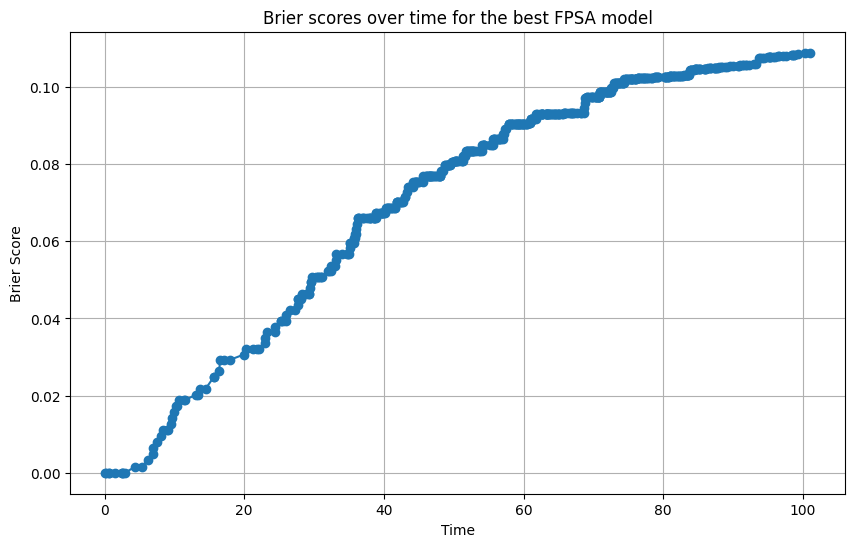

In [ ]:
## Added plotting code
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(times, brier_scores, marker="o")
plt.title("Brier scores over time for the best FPSA model")
plt.xlabel("Time")
plt.ylabel("Brier Score")
plt.grid(True)
plt.show()

In [ ]:
breast_fpsa_times = times
breast_fpsa_brier_scores = brier_scores

In [ ]:
import numpy as np

# save the numpy arrays to the specified directory
np.save('/content/drive/MyDrive/MSc_summer_project/Clinical_trial_data/Breast/Time_depedent_AUC_and_Brier_plots/breast_fpsa_brier_scores', breast_fpsa_brier_scores)
np.save('/content/drive/MyDrive/MSc_summer_project/Clinical_trial_data/Breast/Time_depedent_AUC_and_Brier_plots/breast_fpsa_times.npy', breast_fpsa_times)


In [ ]:
# Define the structured array for training data
train_data_y_structured = np.array(list(zip(train_data_y["disease_free_survival_status"],
                                            train_data_y["disease_free_survival_months"])),
                                   dtype=[('Status', '?'), ('Time', '<f8')])

# Define the structured array for test data
test_data_y_structured = np.array(list(zip(test_data_y["disease_free_survival_status"],
                                           test_data_y["disease_free_survival_months"])),
                                  dtype=[('Status', '?'), ('Time', '<f8')])


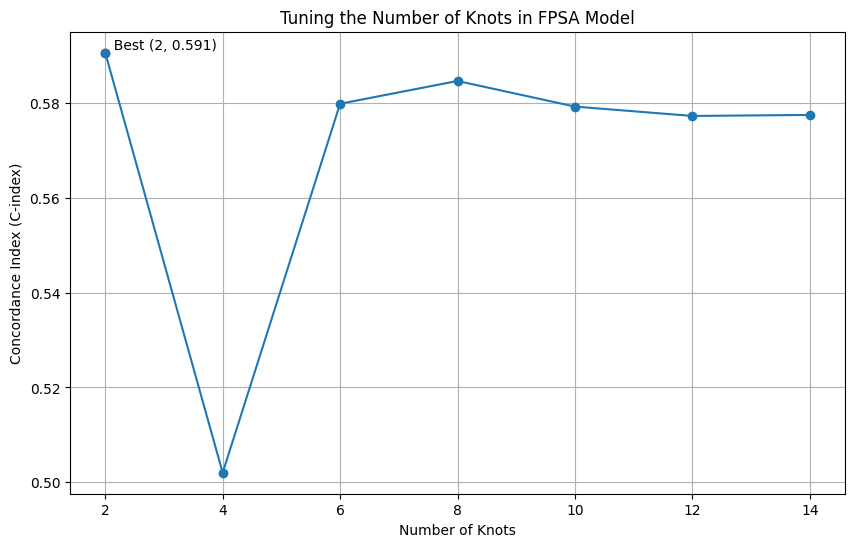

In [ ]:
import matplotlib.pyplot as plt

# the list of knot values you tested
n_knots_values = [2, 4, 6, 8, 10,12,14]

# your calculated c-index scores
c_index_scores = c_index_scores

plt.figure(figsize=(10, 6))

# plot the c-index scores
plt.plot(n_knots_values, c_index_scores, marker='o')

# mark the best number of knots
best_n_knots = n_knots_values[np.argmax(c_index_scores)]
best_c_index = max(c_index_scores)
plt.scatter(best_n_knots, best_c_index, color='red')
plt.text(best_n_knots, best_c_index, f'  Best ({best_n_knots}, {best_c_index:.3f})', verticalalignment='bottom')

plt.title("Tuning the Number of Knots in FPSA Model")
plt.xlabel("Number of Knots")
plt.ylabel("Concordance Index (C-index)")
plt.grid(True)
plt.show()


In [ ]:
# Increasing recommended boostrap iterations to 1000, triaing set only. This is the one I'm going with.
from sklearn.utils import resample

# Number of bootstrap iterations
n_bootstrap_iterations = 200

# Arrays to store bootstrap C-indices and IBS scores
bootstrap_c_indices_fpsa = np.zeros(n_bootstrap_iterations)
bootstrap_ibs_scores_fpsa = np.zeros(n_bootstrap_iterations)

for i in range(n_bootstrap_iterations):
    # Perform bootstrap resampling of the training data
    bootstrap_train_x, bootstrap_train_y = resample(train_data_x, train_data_y)

    # Fit the model using the resampled training data
    cph = CoxPHFitter(baseline_estimation_method="spline", n_baseline_knots=best_n_knots)
    cph.fit(bootstrap_train_x, duration_col='disease_free_survival_months', event_col='disease_free_survival_status')

    # Calculate C-index for the original test data and store it
    c_index = calculate_c_index(cph, test_data_x)
    bootstrap_c_indices_fpsa[i] = c_index

    # Calculate IBS for the original test data and store it
    times = np.sort(test_data_x["disease_free_survival_months"].unique())
    survival = cph.predict_survival_function(test_data_x, times=times)
    brier_scores = []
    for t in times:
        y_true = (test_data_x["disease_free_survival_months"].values <= t) * test_data_x["disease_free_survival_status"]
        y_pred = 1 - survival.loc[t].values
        brier_score = np.mean((y_true - y_pred) ** 2)
        brier_scores.append(brier_score)
    ibs = trapz(brier_scores, times) / (times.max() - times.min())
    bootstrap_ibs_scores_fpsa[i] = ibs

# Compute the lower and upper percentiles for C-index
lower_percentile_c_index = np.percentile(bootstrap_c_indices_fpsa, 2.5)
upper_percentile_c_index = np.percentile(bootstrap_c_indices_fpsa, 97.5)

# Compute the lower and upper percentiles for IBS
lower_percentile_ibs = np.percentile(bootstrap_ibs_scores_fpsa, 2.5)
upper_percentile_ibs = np.percentile(bootstrap_ibs_scores_fpsa, 97.5)

print('Bootstrap 95% confidence interval for the C-index: ({:.2f}, {:.2f})'.format(lower_percentile_c_index, upper_percentile_c_index))
print('Bootstrap 95% confidence interval for the IBS: ({:.2f}, {:.2f})'.format(lower_percentile_ibs, upper_percentile_ibs))


/usr/local/lib/python3.10/dist-packages/lifelines/fitters/__init__.py:2496: ApproximationWarning: Approximating the expected value using trapezoid rule.

  warnings.warn("""Approximating the expected value using trapezoid rule.\n""", exceptions.ApproximationWarning)
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/__init__.py:2496: ApproximationWarning: Approximating the expected value using trapezoid rule.

  warnings.warn("""Approximating the expected value using trapezoid rule.\n""", exceptions.ApproximationWarning)
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/__init__.py:2496: ApproximationWarning: Approximating the expected value using trapezoid rule.

  warnings.warn("""Approximating the expected value using trapezoid rule.\n""", exceptions.ApproximationWarning)
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/__init__.py:2496: ApproximationWarning: Approximating the expected value using trapezoid rule.

  warnings.warn("""Approximating the expected

Bootstrap 95% confidence interval for the C-index: (0.58, 0.67)
Bootstrap 95% confidence interval for the IBS: (0.07, 0.09)


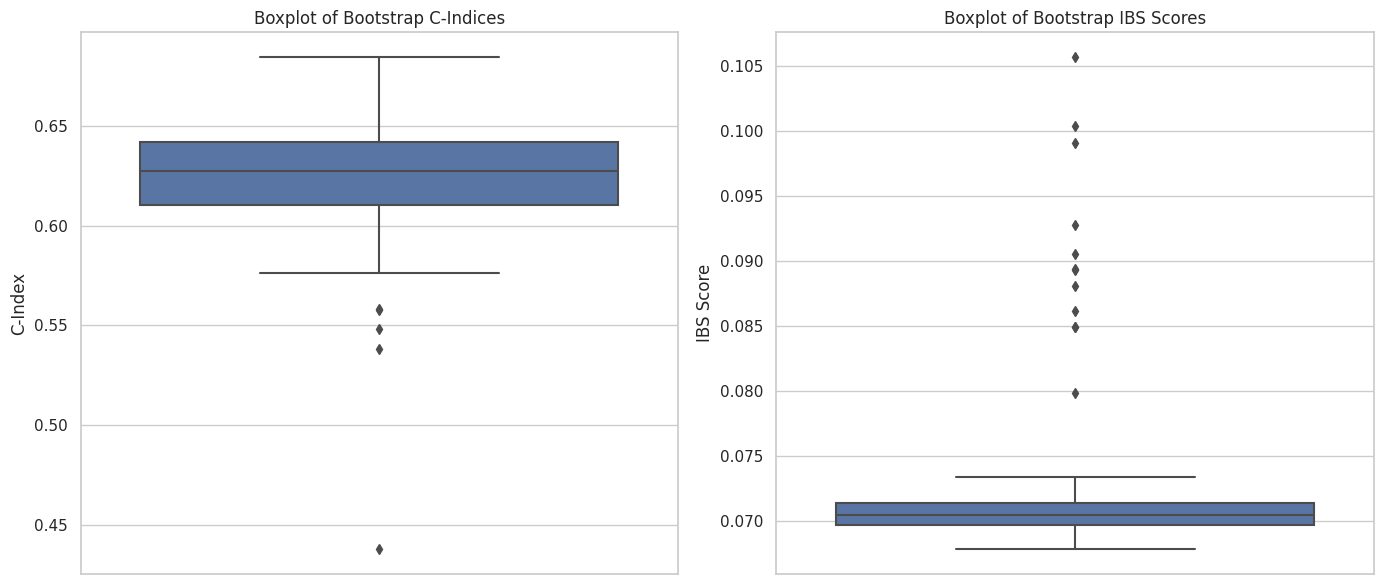

In [ ]:
# Increasing recommended boostrap iterations to 1000. On training dataset only. This is the one I'm going with @  2/8/23.

import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for seaborn
sns.set(style="whitegrid")

# Create a figure
plt.figure(figsize=(14, 6))

# Subplot for C-index
plt.subplot(1, 2, 1)
sns.boxplot(y=bootstrap_c_indices_fpsa)
plt.title("Boxplot of Bootstrap C-Indices")
plt.ylabel("C-Index")

# Subplot for IBS
plt.subplot(1, 2, 2)
sns.boxplot(y=bootstrap_ibs_scores_fpsa)
plt.title("Boxplot of Bootstrap IBS Scores")
plt.ylabel("IBS Score")

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

# save the numpy arrays to the specified directory
np.save('/content/drive/MyDrive/MSc_summer_project/Clinical_trial_data/Breast/Confidence_intervals_breast_IBS_cindex/bootstrap_c_indices_fpsa.npy', bootstrap_c_indices_fpsa)
np.save('/content/drive/MyDrive/MSc_summer_project/Clinical_trial_data/Breast/Confidence_intervals_breast_IBS_cindex/bootstrap_ibs_scores_fpsa.npy', bootstrap_ibs_scores_fpsa)
